In [1]:
# numpy
import numpy as np
from numpy import unravel_index
print( 'Using numpy version %s' % np.__version__ )

# matplotlib and inline display in notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print( 'Using matplotlib version %s' % mpl.__version__ )

# matplotlib toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# scipy
import scipy as scp
from scipy.ndimage import label
from scipy.interpolate import interp1d
from scipy.stats import sigmaclip, iqr
print( 'Using scipy version %s' % scp.__version__ )

# system
import glob, os

# astropy
import astropy as astro
from astropy.table import Table
from astropy.io import ascii, fits
from astropy.stats import sigma_clip
import astropy.units as u
from astropy.cosmology import Planck15
from astropy.convolution import convolve_fft, Box2DKernel
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
print( 'Using astropy version %s' % astro.__version__ )

# photutils
import photutils as phot
from photutils import EllipticalAperture, EllipticalAnnulus, aperture_photometry, CircularAnnulus, CircularAperture, SkyEllipticalAnnulus, SkyEllipticalAperture, SkyCircularAperture, SkyCircularAnnulus
from photutils.detection import DAOStarFinder
print( 'Using photutils version %s' % phot.__version__ )

# text below modifies matplotlib settings so LaTeX can be used in plots
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

def centroid(im,region=None):
    """Compute centroid of image (M10/M00,M01/M00) (x,y), region: use this region to compute centroid"""
    if not(region is None):
        im=im[region[0]:region[1]] #region[2]:region[3]]
        offset=[region[0],region[2]]
    else: 
        offset=[0,0]
    m00=np.sum(im)
    m01=np.sum(np.sum(im,axis=1)*np.arange(im.shape[0]))
    m10=np.sum(np.sum(im,axis=0)*np.arange(im.shape[1]))
    return [m01/m00+offset[0], m10/m00+offset[1]]

Using numpy version 1.21.5
Using matplotlib version 3.5.3
Using scipy version 1.7.3
Using astropy version 4.3.1
Using photutils version 1.1.0


### load catalog

In [2]:
cat_f = ascii.read('./complete_new_ra_dec_photometry_aperture_corrected_seperation_added_euclid_fluxratio_added.csv')
print(cat_f.colnames)

['Unnamed: 0', 'Field', 'CANDELS_ID', 'z', 'RA_gal', 'DEC_gal', 'A', 'Clump_ID', 'dist_clump', 'flux_ratio', 'restuv_flux', 'RA_clump', 'DEC_clump', 'new_X_centroid', 'new_Y_centroid', 'new_RA', 'new_DEC', 'Raw_Flux_f125w_mjy', 'Background_Flux_f125w_mjy', 'Corrected_Flux_f125w_mjy', 'Raw_Flux_f160w_mjy', 'Background_Flux_f160w_mjy', 'Corrected_Flux_f160w_mjy', 'Raw_Flux_f275w_mjy', 'Background_Flux_f275w_mjy', 'Corrected_Flux_f275w_mjy', 'Raw_Flux_f435w_mjy', 'Background_Flux_f435w_mjy', 'Corrected_Flux_f435w_mjy', 'Raw_Flux_f606w_mjy', 'Background_Flux_f606w_mjy', 'Corrected_Flux_f606w_mjy', 'Raw_Flux_f775w_mjy', 'Background_Flux_f775w_mjy', 'Corrected_Flux_f775w_mjy', 'Raw_Flux_f850lp_mjy', 'Background_Flux_f850lp_mjy', 'Corrected_Flux_f850lp_mjy', 'Raw_Flux_f140w_mjy', 'Background_Flux_f140w_mjy', 'Corrected_Flux_f140w_mjy', 'angular_separation_arcsec', 'distance_pixel', 'new_flux_ratio']


### load CANDELS mosaic

In [3]:
f160w_hdu = fits.open('../../CANDELS_data/GOODSS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
print(f160w_hdu.info())

f160w_img = f160w_hdu[0].data
wcs = WCS(f160w_hdu[0].header)

header = f160w_hdu[0].header

f160w_hdu.close()

f160w_convert_factor = header['PHOTFNU']

f435w_hdu = fits.open('../../CANDELS_data/GOODSS/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits')
print(f435w_hdu.info())

f435w_img = f435w_hdu[0].data
wcs_435 = WCS(f435w_hdu[0].header)

header_435 = f435w_hdu[0].header

f435w_hdu.close()

f435w_convert_factor = header_435['PHOTFLAM'] * header_435['PHOTPLAM'] ** 2 * 1e23 / (2.99792458e18)

kernel_435_hdu = fits.open('../../3DHST/GOODSS/goodss_3dhst_v4.0_acs_psf/goodss_3dhst.v4.0.F435W_kernel.fits.gz')
kernel_435 = kernel_435_hdu[0].data
kernel_435_hdu.close()



Filename: ../../CANDELS_data/GOODSS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     151   (32400, 40500)   float32   
None
Filename: ../../CANDELS_data/GOODSS/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (32400, 40500)   float32   
None


### create cutout

1014 0.681


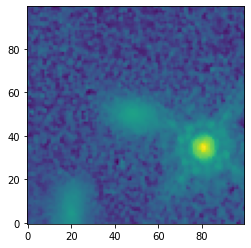

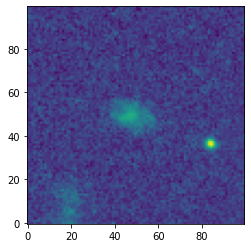

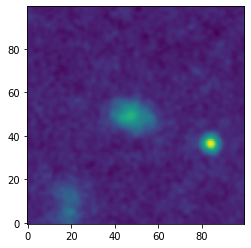

In [40]:
# idx = 7 (CANDELS ID 461) is a great example clump
# idx = 122 (CANDELS ID 16041) is a great example clump
# idx = 25 (CANDELS ID 2155) good multi-clump test case
# idx = 30 (CANDELS ID 2976) is a great example of two clumps
# idx = 145 (CANDELS ID 19186) is a great example containing faint clumps
# idx = 102 (CANDELS ID 10469) is a great example containing two clumps
# idx = 101 (CANDELS ID 10457) is a great example containing two clumps
# idx = 93 (CANDELS ID 9024) is a great example containing a faint clump
idx = 225

print(cat_f['CANDELS_ID'][idx], cat_f['z'][idx])

coords = SkyCoord(cat_f['RA_gal'][idx], cat_f['DEC_gal'][idx], unit='deg')

length= 100

cutout = Cutout2D(f160w_img, coords, (length, length), wcs=wcs)
cutout_435 = Cutout2D(f435w_img, coords, (length, length), wcs=wcs_435)

plt.imshow( np.arcsinh( cutout.data / 0.01 ), origin='lower')
plt.show()

plt.imshow( np.arcsinh( cutout_435.data / 0.01 ), origin='lower')
plt.show()

cutout_435_conv = convolve_fft(cutout_435.data, kernel_435)

plt.imshow( np.arcsinh( cutout_435_conv / 0.01 ), origin='lower')
plt.show()

cutout_wcs = cutout.wcs

print()



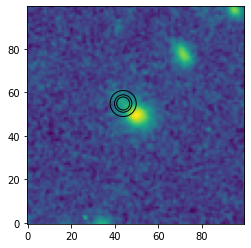

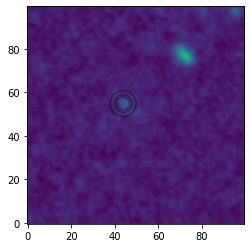

Flux according to Zahra's position: 0.024 uJy
Flux according to Guo+18: 0.072 uJy


In [287]:
x_offset = 0. # in pixels
y_offset = 0. # in pixels

target_coords = SkyCoord(cat_f['RA_clump'][idx] + (x_offset * 0.06/3600), cat_f['DEC_clump'][idx] + (y_offset * 0.06/3600), unit='deg')

target_aperture = SkyCircularAperture(positions=target_coords, r=0.18 * u.arcsec).to_pixel(wcs=cutout_wcs)
bckg_annulus = SkyCircularAnnulus(positions=target_coords, r_in=0.24 * u.arcsec, r_out=0.36 * u.arcsec).to_pixel(wcs=cutout_wcs)

plt.imshow( np.arcsinh( cutout.data / 0.01 ), origin='lower')

target_aperture.plot()
bckg_annulus.plot()

plt.show()

plt.imshow( np.arcsinh( cutout_435_conv / 0.01 ), origin='lower', vmax=2.5)

target_aperture.plot(alpha=0.5)
bckg_annulus.plot(alpha=0.5)

plt.show()

phot_table_target = aperture_photometry(data=cutout.data, apertures=target_aperture)
phot_table_bckg = aperture_photometry(data=cutout.data, apertures=bckg_annulus)

target_flux = phot_table_target['aperture_sum'][0]
bckg_flux = phot_table_bckg['aperture_sum'][0]

bckg_corr = target_aperture.area * bckg_flux / bckg_annulus.area

print( "Flux according to Zahra's position: %.3f uJy" % (1.5 * f160w_convert_factor * (target_flux - bckg_corr) * 1e6) )
print( "Flux according to Guo+18: %.3f uJy" % cat_f['F160W'][idx] )


### create mask centered on position from Zahra's code

In [9]:
print( (cat_f['RA_clump'][idx] - cat_f['new_RA'][idx]) * 3600 )
print( (cat_f['DEC_clump'][idx] - cat_f['new_DEC'][idx]) * 3600 )

-0.04812956292710169
0.03000382543376645


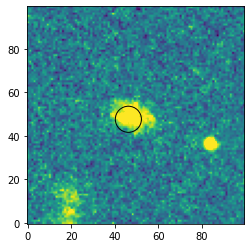

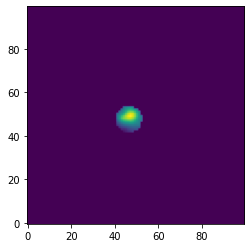

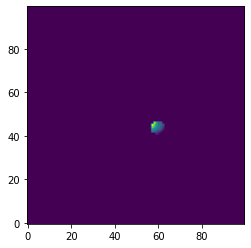

In [41]:

target_coords = SkyCoord(cat_f['new_RA'][idx], cat_f['new_DEC'][idx], unit='deg')

target_aperture = SkyCircularAperture(positions=target_coords, r=0.36 * u.arcsec).to_pixel(wcs=cutout_435.wcs)

plt.imshow( np.arcsinh( cutout_435.data / 0.01 ), origin='lower', vmax=1.5)

target_aperture.plot()

plt.show()

mask = target_aperture.to_mask(method='center')
mask_img = mask.to_image(cutout_435_conv.shape)

other_clump = CircularAperture(positions=(59.36, 43.70), r=0.18 / 0.06)
other_mask = other_clump.to_mask(method='center')
other_mask_img = other_mask.to_image(cutout_435_conv.shape)

plt.imshow( mask_img * cutout_435_conv, origin='lower')

plt.show()

plt.imshow( other_mask_img * cutout_435_conv, origin='lower')

plt.show()

### run centroid code on masked portion of image

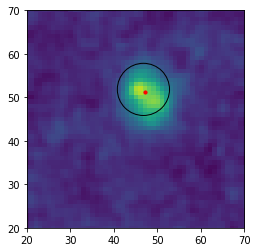

In [199]:
new_y, new_x = centroid(mask_img * cutout_435_conv)

plt.imshow( np.arcsinh( cutout_435_conv / 0.01 ), origin='lower', vmax=2)

plt.scatter(new_x, new_y, c='r', s=10)

target_aperture.plot()

plt.xlim(20, 70)
plt.ylim(20, 70)

plt.show()


Flux according to UPDATED position: 0.668 uJy
Flux according to Guo+18: 0.761 uJy


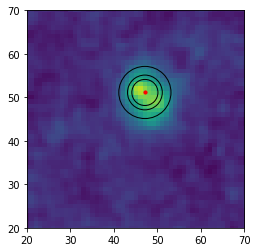

In [201]:
new_target_aperture = CircularAperture(positions=(new_x, new_y), r=0.18/0.06)
new_bckg_annulus = CircularAnnulus(positions=(new_x, new_y), r_in=0.24/0.06, r_out=0.36/0.06)

new_phot_table_target = aperture_photometry(data=cutout.data, apertures=new_target_aperture)
new_phot_table_bckg = aperture_photometry(data=cutout.data, apertures=new_bckg_annulus)

new_target_flux = new_phot_table_target['aperture_sum'][0]
new_bckg_flux = new_phot_table_bckg['aperture_sum'][0]

new_bckg_corr = new_target_aperture.area * new_bckg_flux / new_bckg_annulus.area

print( "Flux according to UPDATED position: %.3f uJy" % (1.5 * f160w_convert_factor * (new_target_flux - new_bckg_corr) * 1e6) )
print( "Flux according to Guo+18: %.3f uJy" % cat_f['F160W'][idx] )

plt.imshow( np.arcsinh( cutout_435_conv / 0.01 ), origin='lower', vmax=2)

plt.scatter(new_x, new_y, c='r', s=10)

new_target_aperture.plot()
new_bckg_annulus.plot()

plt.xlim(20, 70)
plt.ylim(20, 70)

plt.show()

### create contrast image

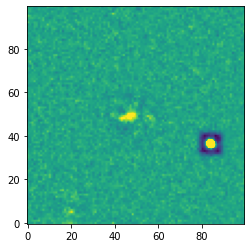

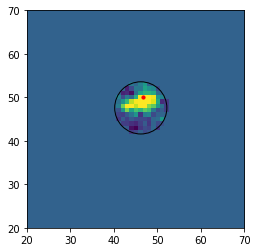

In [42]:
smooth_kernel = Box2DKernel(width=10.)

smooth_img = convolve_fft( cutout_435.data, smooth_kernel )

contrast_img = cutout_435.data - smooth_img

plt.imshow( contrast_img, origin='lower', vmax=0.03 )

plt.show()

new_y, new_x = centroid(mask_img * contrast_img)

plt.imshow( mask_img * contrast_img, origin='lower', vmax=0.03)

plt.scatter(new_x, new_y, c='r', s=10)

target_aperture.plot()

plt.xlim(20, 70)
plt.ylim(20, 70)

plt.show()


### searching for clumps using DAOFinder

 id     xcentroid          ycentroid          sharpness      ... sky         peak         flux mag 
--- ------------------ ------------------ ------------------ ... --- -------------------- ---- ----
  1  43.98030473533879 48.356214128362275 0.4421965560851189 ... 0.0  0.02947085081041151  inf -inf
  2  46.93519516986028   49.1332701761024 0.5113002549091706 ... 0.0  0.05239352663685598  inf -inf
  3 50.490959420027494 49.586451854257234 0.3535877675942625 ... 0.0  0.02961986424047639  inf -inf
  4  46.89641097233818 52.180683333509535 0.7513003830380648 ... 0.0 0.027881357738038223  inf -inf 1


/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/photutils/detection/daofinder.py:531: RuntimeWarning: divide by zero encountered in double_scalars
  return ((self.conv_peak / self.cutout.threshold_eff)


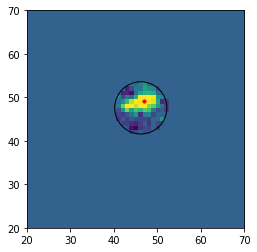

In [43]:
daofind = DAOStarFinder(fwhm=2., threshold=np.median(mask_img * cutout_435_conv))

sources = daofind((mask_img * cutout_435_conv))

print(sources, sources['peak'].argmax())

plt.imshow( mask_img * contrast_img, origin='lower', vmax=0.03)

max_bright_idx = sources['peak'].argmax()

plt.scatter(sources['xcentroid'][max_bright_idx], sources['ycentroid'][max_bright_idx], c='r', s=10)

#plt.scatter( 59.36, 43.70 )

target_aperture.plot()

plt.xlim(20, 70)
plt.ylim(20, 70)

plt.show()

new_x, new_y = sources['xcentroid'][max_bright_idx], sources['ycentroid'][max_bright_idx]


In [44]:
ra_435, dec_435 = cutout_435.wcs.all_pix2world(new_x, new_y, 1)

print( (ra_435 - cat_f['new_RA'][idx]) * 3600 )
print( (dec_435 - cat_f['new_DEC'][idx]) * 3600 )


0.030836517058219215
0.023168939739548478


In [48]:
target_coords = SkyCoord(cat_f['new_RA'][idx], cat_f['new_DEC'][idx], unit='deg')

target_aperture = SkyCircularAperture(positions=target_coords, r=0.18 * u.arcsec).to_pixel(wcs=cutout_435.wcs)

bckg_annulus = SkyCircularAnnulus(positions=target_coords, r_in=0.24 * u.arcsec, r_out=0.36 * u.arcsec).to_pixel(wcs=cutout_435.wcs)

phot_table_target = aperture_photometry(data=cutout_435_conv, apertures=target_aperture)
phot_table_bckg = aperture_photometry(data=cutout_435_conv, apertures=bckg_annulus)

target_flux = phot_table_target['aperture_sum'][0]
bckg_flux = phot_table_bckg['aperture_sum'][0]

bckg_corr = target_aperture.area * bckg_flux / bckg_annulus.area

print( "F435W Flux according to F275W position: %.4f uJy" % (1.5 * f435w_convert_factor * (target_flux - bckg_corr) * 1e6) )

# using coordinates from F435W image
target_coords_435 = SkyCoord(ra_435, dec_435, unit='deg')

target_aperture_435 = SkyCircularAperture(positions=target_coords_435, r=0.18 * u.arcsec).to_pixel(wcs=cutout_435.wcs)

bckg_annulus_435 = SkyCircularAnnulus(positions=target_coords_435, r_in=0.24 * u.arcsec, r_out=0.36 * u.arcsec).to_pixel(wcs=cutout_435.wcs)

phot_table_target = aperture_photometry(data=cutout_435_conv, apertures=target_aperture_435)
phot_table_bckg = aperture_photometry(data=cutout_435_conv, apertures=bckg_annulus_435)

target_flux = phot_table_target['aperture_sum'][0]
bckg_flux = phot_table_bckg['aperture_sum'][0]

bckg_corr = target_aperture.area * bckg_flux / bckg_annulus.area

print( "F435W Flux according to F435W position: %.4f uJy" % (1.5 * f435w_convert_factor * (target_flux - bckg_corr) * 1e6) )


F435W Flux according to F275W position: 0.1505 uJy
F435W Flux according to F435W position: 0.1587 uJy


In [32]:
np.sqrt(0.01 ** 2 + 0.01 ** 2)

0.01414213562373095

### PSF aperture correction

/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


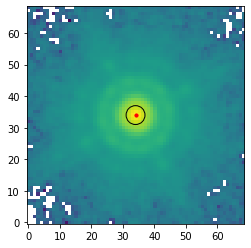

(69, 69)
0.5736098049269682
1.7433453741735108


In [70]:
psf_hdu = fits.open('/Volumes/Vega/3DHST/GOODSS/goodss_3dhst_v4.0_wfc3_psf/goodss_3dhst.v4.0.F160W_psf.fits.gz')
psf_img = psf_hdu[0].data
psf_hdu.close()

aper = CircularAperture(positions=(34, 34), r=0.18/0.06)

plt.imshow( np.log10(psf_img), origin='lower' )

plt.scatter( 34, 34, c='r', s=10 )
aper.plot()
#plt.xlim(25, 50)
#plt.ylim(25, 50)

plt.show()

print( psf_img.shape )

phot_table = aperture_photometry(psf_img, apertures=aper)

print(phot_table['aperture_sum'][0] / np.sum(psf_img))

aper_corr = 1 / (phot_table['aperture_sum'][0] / np.sum(psf_img))

print(aper_corr)
